Loaded trained model from disk.


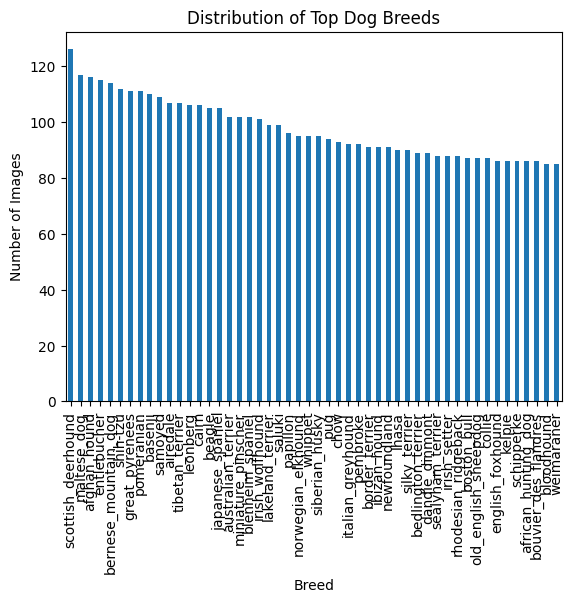

Preprocessing images...


100%|██████████| 4890/4890 [00:19<00:00, 253.77it/s]


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join, isfile
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
import pickle
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from tqdm import tqdm

# Directory setup - these paths should be updated according to your local setup
data_dir = 'data'  # The directory containing the dataset
labels_path = join(data_dir, 'labels.csv')  # Path to the labels file
model_path = 'logreg_model.pkl'  # Path where the trained model will be saved

# Parameters
INPUT_SIZE = 224  # Size of the input images (224x224 pixels is standard for VGG16)
NUM_CLASSES = 40  # Number of classes to consider (reduced for performance and speed) # DEFAULT : 120

# Function to read and preprocess images
def read_img(img_id, train_or_test, size):
    """
    Reads an image from disk and preprocesses it.
    
    Args:
    - img_id: ID of the image file.
    - train_or_test: Directory of the image (train or test).
    - size: New size of the image (tuple).
    
    Returns:
    - Preprocessed image array.
    """
    img_path = join(data_dir, train_or_test, img_id + '.jpg')  # Constructing the full path of the image
    img = image.load_img(img_path, target_size=size)  # Loading the image
    img = image.img_to_array(img)  # Converting image to array
    img = np.expand_dims(img, axis=0)  # Adding an extra dimension for batching
    return img

# Load the model from disk if it exists
if isfile(model_path):
    with open(model_path, 'rb') as f:
        logreg = pickle.load(f)  # Loading trained logistic regression model from disk
    print("Loaded trained model from disk.")
    labels = pd.read_csv(labels_path)  # Reading labels CSV file into a DataFrame
    selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)  # Selecting top classes
    labels = labels[labels['breed'].isin(selected_breed_list)]  # Filtering labels for selected classes
    
    # Visualize the distribution of the top breeds
    labels['breed'].value_counts().plot(kind='bar')  # Plotting class distribution
    plt.title('Distribution of Top Dog Breeds')
    plt.xlabel('Breed')
    plt.ylabel('Number of Images')
    plt.show()
    
    # Preprocess the images
    x = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')  # Initializing array for preprocessed images
    print("Preprocessing images...")
    for i, img_id in tqdm(enumerate(labels['id']), total=len(labels)):  # Iterating through image IDs
        img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))  # Reading and preprocessing image
        x[i] = preprocess_input(img)  # Preprocessing input image
    
    # Encode labels as one-hot
    target_series = pd.Series(labels['breed'])  # Extracting labels
    one_hot = pd.get_dummies(target_series, sparse=True)  # One-hot encoding labels
    one_hot_labels = np.asarray(one_hot)  # Converting encoded labels to array
    

else:
    print("Model not found. Starting training process.")
    # Load and preprocess the data
    labels = pd.read_csv(labels_path)  # Reading labels CSV file into a DataFrame
    selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)  # Selecting top classes
    labels = labels[labels['breed'].isin(selected_breed_list)]  # Filtering labels for selected classes
    
    # Visualize the distribution of the top breeds
    labels['breed'].value_counts().plot(kind='bar')  # Plotting class distribution
    plt.title('Distribution of Top Dog Breeds')
    plt.xlabel('Breed')
    plt.ylabel('Number of Images')
    plt.show()
    
    # Preprocess the images
    x = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')  # Initializing array for preprocessed images
    print("Preprocessing images...")
    for i, img_id in tqdm(enumerate(labels['id']), total=len(labels)):  # Iterating through image IDs
        img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))  # Reading and preprocessing image
        x[i] = preprocess_input(img)  # Preprocessing input image
    
    # Encode labels as one-hot
    target_series = pd.Series(labels['breed'])  # Extracting labels
    one_hot = pd.get_dummies(target_series, sparse=True)  # One-hot encoding labels
    one_hot_labels = np.asarray(one_hot)  # Converting encoded labels to array
    
    # Split the dataset into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, one_hot_labels, test_size=0.2, random_state=42)  # Splitting dataset
    
    # Extract features using VGG16
    print("Extracting features using VGG16...")
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3), pooling='avg')  # Loading VGG16 model
    features_train = vgg16.predict(x_train, batch_size=32, verbose=1)  # Extracting features for training set
    features_val = vgg16.predict(x_val, batch_size=32, verbose=1)  # Extracting features for validation set
    
    # Train the logistic regression model
    print("Training logistic regression model...")
    logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)  # Initializing logistic regression model
    logreg.fit(features_train, np.argmax(y_train, axis=1))  # Fitting logistic regression model
    
    # Evaluate the model
    train_preds = logreg.predict(features_train)  # Making predictions on training set
    val_preds = logreg.predict(features_val)  # Making predictions on validation set
    print(f'Training Accuracy: {accuracy_score(np.argmax(y_train, axis=1), train_preds)}')  # Calculating training accuracy
    print(f'Validation Accuracy: {accuracy_score(np.argmax(y_val, axis=1), val_preds)}')  # Calculating validation accuracy
    
    # Save the trained model to disk
    with open(model_path, 'wb') as f:
        pickle.dump(logreg, f)  # Saving trained model to disk
    print("Trained model saved to disk.")

# Prediction function
def predict_breed(img_path):
    """
    Predicts the dog breed for a given image.
    
    Args:
    - img_path: Path to the image file.
    
    Displays:
    - The image and the predicted breed.
    """
    img = image.load_img(img_path, target_size=(INPUT_SIZE, INPUT_SIZE))  # Loading image
    img = image.img_to_array(img)  # Converting image to array
    img = np.expand_dims(img, axis=0)  # Adding an extra dimension for batching
    img = preprocess_input(img)  # Preprocessing input image
    
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3), pooling='avg')  # Loading VGG16 model
    features = vgg16.predict(img)  # Extracting features from image
    
    prediction = logreg.predict(features)[0]  # Making prediction using trained model
    predicted_breed = selected_breed_list[prediction]  # Getting predicted breed
    
    plt.imshow(plt.imread(img_path))  # Displaying the image
    plt.title(f"Predicted Breed: {predicted_breed}")  # Setting title with predicted breed
    plt.axis('off')  # Turning off axis
    plt.show()  # Displaying the plot


## FOR PREDICTION

In [8]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input

# Assuming predict_breed function returns the breed name as a string
def predict_breed(img_path):
    """
    Predicts the dog breed for a given image using the pre-trained logistic regression model.
    
    Args:
    - img_path: Path to the image file.
    
    Returns:
    - Predicted breed name as a string.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Load image
    img = image.img_to_array(img)  # Convert image to array
    img = np.expand_dims(img, axis=0)  # Add an extra dimension for batching
    img = preprocess_input(img)  # Preprocess input image
    
    # Use VGG16 for feature extraction
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')  # Load VGG16 model
    features = vgg16.predict(img)  # Extract features from image
    
    # Predict using the logistic regression model
    predicted_class = logreg.predict(features)[0]  # Make prediction using trained model
    predicted_breed = selected_breed_list[predicted_class]  # Get predicted breed name
    
    return predicted_breed


def select_image():
    """Open a file dialog to select an image, predict the dog breed, and display the image."""
    file_path = filedialog.askopenfilename()  # Open file dialog to select an image
    if file_path:  # Proceed if a file was selected
        predicted_breed = predict_breed(file_path)  # Predict the breed of the selected image
        show_image(file_path, predicted_breed)  # Display the image and predicted breed


def show_image(file_path, predicted_breed):
    """Display the selected image and predicted breed in the GUI."""
    image = Image.open(file_path)  # Open the selected image
    image = image.resize((250, 250), Image.Resampling.LANCZOS)  # Resize to fit the GUI window
    photo = ImageTk.PhotoImage(image)  # Convert image to PhotoImage
    
    # Clear previous widgets
    for widget in frame.winfo_children():
        widget.destroy()
    
    # Display the image
    image_label = tk.Label(frame, image=photo)  # Create label for image
    image_label.image = photo  # Keep a reference to the image
    image_label.pack()  # Pack the image label
    
    # Display the predicted breed
    breed_label = tk.Label(frame, text=f"Predicted Breed: {predicted_breed}")  # Create label for predicted breed
    breed_label.pack()  # Pack the breed label
    
    # Add the "Next" button
    btn_next_image = tk.Button(frame, text="Next", command=select_image)  # Create "Next" button
    btn_next_image.pack(fill=tk.X)  # Pack the "Next" button


# Create the main window
root = tk.Tk()  # Initialize main window
root.title("Dog Breed Predictor")  # Set window title

# Create a frame to hold the GUI elements
frame = tk.Frame(root)  # Initialize frame
frame.pack(padx=10, pady=10)  # Pack the frame with padding

# Add a button to open the file dialog
btn_select_image = tk.Button(frame, text="Select an Image", command=select_image)  # Initialize "Select an Image" button
btn_select_image.pack(fill=tk.X)  # Pack the "Select an Image" button

root.mainloop()  # Run the GUI application


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
